In [32]:
import re
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
%matplotlib inline

## Load Fuana Dataset

In [33]:
df = pd.read_csv('../data/fauna20k.csv.gz', compression='gzip')

## Visualize the number of records in each class

rodentia            1956
passeriformes       1082
chiroptera           836
coleoptera           808
squamata             796
lepidoptera          671
testudines           584
saurischia           579
artiodactyla         540
diptera              531
carnivora            516
eulipotyphla         503
therapsida           393
hymenoptera          374
ornithischia         343
accipitriformes      315
galliformes          296
hemiptera            292
primates             287
multituberculata     283
Name: order, dtype: int64


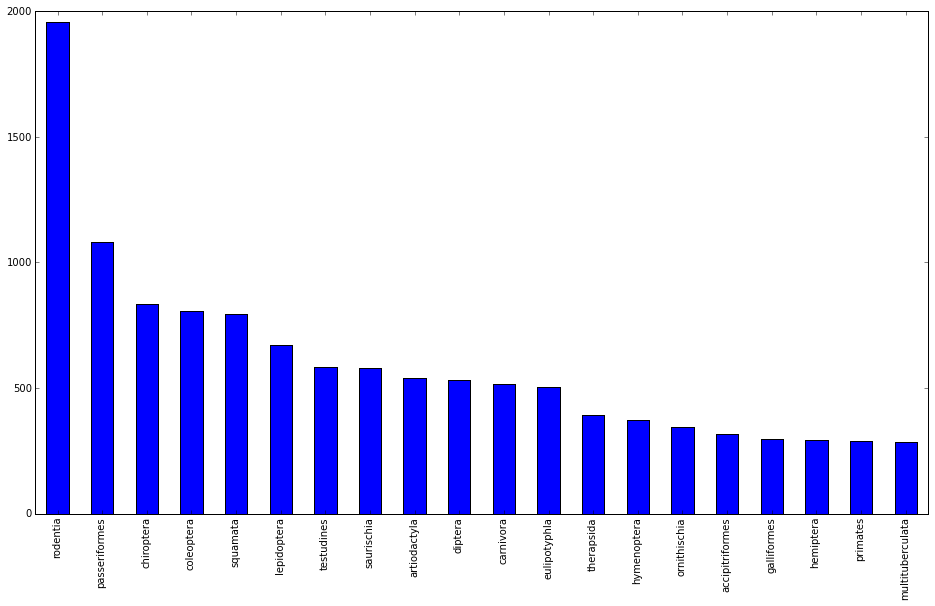

In [34]:
classes = df['order'].value_counts()
print(classes.head(20))
figure(figsize=(16, 9))
classes[0:20].plot(kind="bar")

In [35]:
df = df.drop_duplicates()
df[df.duplicated()==True]
df.set_index(keys=['page-id'])

,class,family,genus,kingdom,order,phylum,species,superorder,text,title
page-id,,,,,,,,,,
568834,aves,alcedinidae,halcyon,animalia,coraciiformes,chordata,hpileata,NaN,The black-capped kingfisher (Halcyon pileata) ...,Black-capped kingfisher
12432043,aves,alcedinidae,todiramphus,animalia,coraciiformes,chordata,tmacleayii,NaN,"The forest kingfisher (Todiramphus macleayii),...",Forest kingfisher
335568,mammalia,cervidae,damafrisch1775,animalia,artiodactyla,chordata,ddama,NaN,The fallow deer (Latin: Dama dama) is a rumina...,Fallow deer
59746,arachnida,sicariidae,loxosceles,animalia,araneae,arthropoda,lreclusa,NaN,"The brown recluse, Loxosceles reclusa, Sicarii...",Brown recluse spider
1973939,mammalia,cervidae,odocoileus,animalia,artiodactyla,chordata,ovirginianus,NaN,This is a redirect from the scientific name of...,Odocoileus virginianus
3509682,NaN,NaN,cearadactylusleonardiborgomanero1985,animalia,pterosauria,chordata,catrox,NaN,Cearadactylus is a genus of large Early Cretac...,Cearadactylus
1087031,mammalia,bovidae,litocraniuskohl1886,animalia,artiodactyla,chordata,lwalleri,NaN,The gerenuk Somali: garanuug (pronounced /\ˈge...,Gerenuk
2059365,mammalia,bovidae,redunca,animalia,artiodactyla,chordata,rredunca,NaN,The bohor reedbuck (Redunca redunca) is an ant...,Bohor reedbuck
663697,mammalia,cheirogaleidae,microcebus,animalia,primates,chordata,mmurinus,NaN,"The gray mouse lemur (Microcebus murinus), gre...",Gray mouse lemur


### Create a word count dataframe

In [36]:
count = 0
limit = df.shape[0]
words = {}
word_count_history = []
tf = {}
df = {}

#   page-id
#tf[234234] = {'word' : count}
#df['word']

for index, row in df.iterrows():
    if count < limit and row['text'] != '':
        count += 1
        word_count_history.append(len(words))
        # remove puncuation and extra spaces, transfrom to lower case and split on spaces
        word_list = re.sub(r'\W+', ' ', str(row['text']).lower()).split(' ')
        for word in word_list:
            if word:
                if word in words:
                    words[word] += 1
                else:
                    words[word] = 1
                    
                    
terms = pd.Series()
term_frequency = pd.Series()
document_frequency = pd.Series()

In [37]:
word_counts = pd.Series(words)
word_counts.sort(ascending=False)
word_counts.head(15)

/Users/jeremy/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  from ipykernel import kernelapp as app


the        543206
of         263991
and        262232
in         222250
to         176684
a          168367
is         131710
are         91480
as          70710
species     61794
from        58193
it          57724
with        57557
that        51559
on          48486
dtype: int64

### Just for fun, how does the number of words increase as we count occurences?

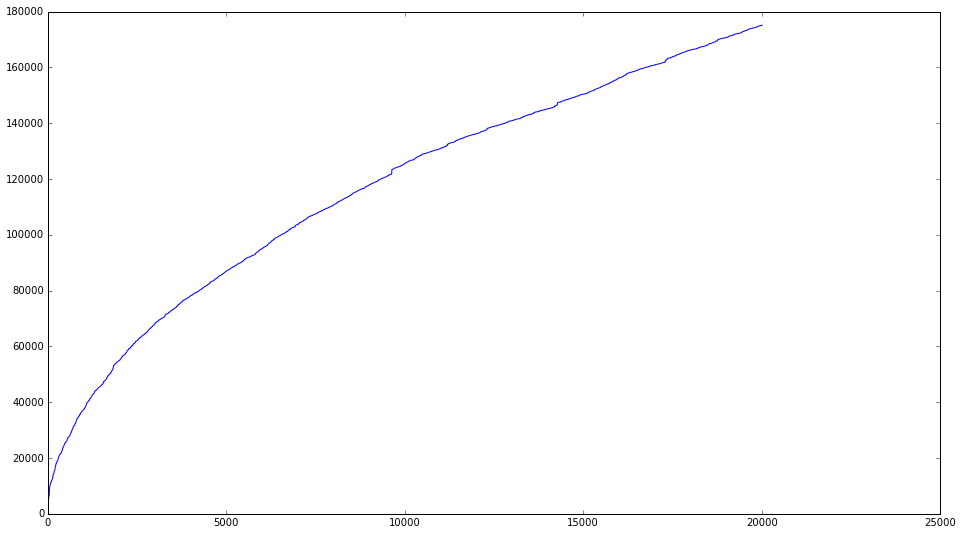

In [38]:
figure(figsize=(16, 9))
plot(word_count_history)